In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),  # CIFAR-100 stats
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])


In [3]:
# Model Architecture (ResNet-18)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [5]:
# Custom Datasets
class LabeledDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Convert numpy array to PIL Image
        image = Image.fromarray(self.images[idx])
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

class UnlabeledDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Convert numpy array to PIL Image
        image = Image.fromarray(self.images[idx])
        
        if self.transform:
            image = self.transform(image)
            
        return image


In [6]:
# Training Functions
def train_cifar100(model, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    acc = 100.*correct/total
    print(f'Epoch: {epoch} | Loss: {train_loss/(batch_idx+1):.3f} | Acc: {acc:.3f}%')
    return train_loss/(batch_idx+1), acc


In [7]:
def pseudo_labeling_train(model, labeled_loader, unlabeled_loader, optimizer, criterion_labeled, criterion_unlabeled, epoch, threshold=0.95, alpha=0.1):
    model.train()
    total_loss = 0
    labeled_correct = 0
    labeled_total = 0
    
    labeled_iter = iter(labeled_loader)
    unlabeled_iter = iter(unlabeled_loader)
    
    for batch_idx in range(max(len(labeled_loader), len(unlabeled_loader))):
        # Labeled data
        try:
            inputs_labeled, targets_labeled = next(labeled_iter)
            inputs_labeled, targets_labeled = inputs_labeled.to(device), targets_labeled.to(device)
            labeled = True
        except StopIteration:
            labeled = False
        
        # Unlabeled data
        try:
            inputs_unlabeled = next(unlabeled_iter)
            inputs_unlabeled = inputs_unlabeled.to(device)
            unlabeled = True
        except StopIteration:
            unlabeled = False
        
        optimizer.zero_grad()
        
        # Combined loss
        loss = 0
        
        # Labeled loss
        if labeled:
            outputs_labeled = model(inputs_labeled)
            loss_labeled = criterion_labeled(outputs_labeled, targets_labeled)
            _, predicted_labeled = outputs_labeled.max(1)
            labeled_total += targets_labeled.size(0)
            labeled_correct += predicted_labeled.eq(targets_labeled).sum().item()
            loss += loss_labeled
        
        # Unlabeled loss with pseudo-labels
        if unlabeled:
            with torch.no_grad():
                outputs_unlabeled = model(inputs_unlabeled)
                probs = torch.softmax(outputs_unlabeled, dim=1)
                max_probs, pseudo_labels = probs.max(dim=1)
                mask = max_probs.ge(threshold).float()
            
            # Compute unlabeled loss only if we have confident predictions
            if mask.sum() > 0:
                outputs_unlabeled = model(inputs_unlabeled)
                loss_unlabeled = criterion_unlabeled(outputs_unlabeled, pseudo_labels)
                # Multiply by mask before taking mean to keep it as a tensor
                loss_unlabeled = (loss_unlabeled * mask).mean()
                loss += alpha * loss_unlabeled
        
        # Backpropagate only if we have a loss to backprop
        if isinstance(loss, torch.Tensor):
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item() if isinstance(loss, torch.Tensor) else loss
    
    acc = 100.*labeled_correct/labeled_total if labeled_total > 0 else 0
    print(f'Epoch: {epoch} | Loss: {total_loss/(batch_idx+1):.3f} | Labeled Acc: {acc:.3f}%')
    return total_loss/(batch_idx+1), acc

In [8]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    acc = 100.*correct/total
    print(f'Test Loss: {test_loss/(batch_idx+1):.3f} | Test Acc: {acc:.3f}%')
    return test_loss/(batch_idx+1), acc, all_preds, all_labels


In [9]:
# Visualization Functions
def plot_training_history(train_loss_history, train_acc_history, test_acc_history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Training Accuracy')
    plt.plot(test_acc_history, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [10]:
def plot_tsne(model, test_loader, n_samples=1000):
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            if i * test_loader.batch_size >= n_samples:
                break
            inputs = inputs.to(device)
            
            # Extract features before final layer
            out = model.conv1(inputs)
            out = model.bn1(out)
            out = torch.relu(out)
            out = model.layer1(out)
            out = model.layer2(out)
            out = model.layer3(out)
            out = model.layer4(out)
            out = nn.functional.avg_pool2d(out, 4)
            out = out.view(out.size(0), -1)
            
            features.append(out.cpu().numpy())
            labels.append(targets.numpy())
    
    features = np.concatenate(features)[:n_samples]
    labels = np.concatenate(labels)[:n_samples]
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features)
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, ticks=range(10))
    plt.title('t-SNE Visualization of CIFAR-10 Test Features')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()


In [11]:
def plot_confusion_matrix(all_preds, all_labels):
    cm = confusion_matrix(all_labels, all_preds)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize
    
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [12]:
def plot_sample_predictions(model, test_loader, num_samples=12):
    samples, true_labels = next(iter(test_loader))
    samples, true_labels = samples[:num_samples].to(device), true_labels[:num_samples]
    
    model.eval()
    with torch.no_grad():
        outputs = model(samples)
        _, pred_labels = torch.max(outputs, 1)
    
    samples = samples.cpu()
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        plt.subplot(3, 4, i+1)
        img = samples[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.2675, 0.2565, 0.2761]) + np.array([0.5071, 0.4867, 0.4408])  # Unnormalize
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f'True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [13]:
# Main Workflow
def main():
    # Create directories
    os.makedirs('checkpoints', exist_ok=True)
    
    # Load CIFAR-100
    cifar100_trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    cifar100_trainloader = DataLoader(cifar100_trainset, batch_size=128, shuffle=True)
    
    # Phase 1: Train on CIFAR-100
    print("Phase 1: Training on CIFAR-100")
    model = ResNet18().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
    
    cifar100_train_loss = []
    cifar100_train_acc = []
    
    for epoch in range(45):
        loss, acc = train_cifar100(model, cifar100_trainloader, optimizer, criterion, epoch)
        scheduler.step()
        cifar100_train_loss.append(loss)
        cifar100_train_acc.append(acc)
    
    # Save CIFAR-100 model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, 'checkpoints/cifar100_pretrained.pth')
    
    # Phase 2: Transfer to CIFAR-10 with Pseudo-Labeling
    print("\nPhase 2: Transfer Learning on CIFAR-10 with Pseudo-Labeling")
    
    # Load CIFAR-10
    full_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    
    # Split CIFAR-10
    train_images, unlabeled_images, train_labels, unlabeled_labels = train_test_split(
        full_train_set.data, full_train_set.targets, test_size=0.95, random_state=42, stratify=full_train_set.targets
    )
    
    # Create datasets
    labeled_train_set = LabeledDataset(train_images, train_labels, transform_train)
    unlabeled_train_set = UnlabeledDataset(unlabeled_images, transform_train)
    test_loader = DataLoader(test_set, batch_size=100, shuffle=False)
    
    # Create dataloaders
    labeled_loader = DataLoader(labeled_train_set, batch_size=128, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_train_set, batch_size=128, shuffle=True)
    
    # Load pretrained model and modify for CIFAR-10
    model = ResNet18().to(device)
    checkpoint = torch.load('checkpoints/cifar100_pretrained.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.linear = nn.Linear(512, 10).to(device)  # Change to CIFAR-10 classes
    
    # Freeze all layers except the final one
    for param in model.parameters():
        param.requires_grad = False
    for param in model.linear.parameters():
        param.requires_grad = True
    
    # New optimizer for fine-tuning
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion_labeled = nn.CrossEntropyLoss()
    criterion_unlabeled = nn.CrossEntropyLoss()
    
    # Training metrics
    train_loss_history = []
    train_acc_history = []
    test_acc_history = []
    
    # Pseudo-labeling training
    # Training loop with the fixed function
    for epoch in range(35):
        # Train with pseudo-labeling
        train_loss, train_acc = pseudo_labeling_train(
            model, labeled_loader, unlabeled_loader, optimizer,
            criterion_labeled, criterion_unlabeled, epoch
        )
        
        # Evaluate on test set
        test_loss, test_acc, all_preds, all_labels = evaluate(model, test_loader, criterion_labeled)
        
        # Store metrics for visualization
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)
    
    # Phase 3: Visualization
    print("\nPhase 3: Visualization")
    
    # Training history
    plot_training_history(train_loss_history, train_acc_history, test_acc_history)
    
    # t-SNE visualization
    plot_tsne(model, test_loader)
    
    # Confusion matrix
    plot_confusion_matrix(all_preds, all_labels)
    
    # Sample predictions
    plot_sample_predictions(model, test_loader)
    
    # Save final model
    torch.save(model.state_dict(), 'checkpoints/cifar10_final_model.pth')


Files already downloaded and verified
Phase 1: Training on CIFAR-100
Epoch: 0 | Loss: 3.985 | Acc: 8.536%
Epoch: 1 | Loss: 3.333 | Acc: 18.490%
Epoch: 2 | Loss: 2.813 | Acc: 28.204%
Epoch: 3 | Loss: 2.370 | Acc: 37.178%
Epoch: 4 | Loss: 2.053 | Acc: 43.822%
Epoch: 5 | Loss: 1.856 | Acc: 48.366%
Epoch: 6 | Loss: 1.717 | Acc: 52.084%
Epoch: 7 | Loss: 1.626 | Acc: 54.258%
Epoch: 8 | Loss: 1.546 | Acc: 56.118%
Epoch: 9 | Loss: 1.474 | Acc: 58.140%
Epoch: 10 | Loss: 1.422 | Acc: 59.374%
Epoch: 11 | Loss: 1.378 | Acc: 60.698%
Epoch: 12 | Loss: 1.326 | Acc: 61.946%
Epoch: 13 | Loss: 1.303 | Acc: 62.374%
Epoch: 14 | Loss: 1.271 | Acc: 63.258%
Epoch: 15 | Loss: 1.238 | Acc: 64.070%
Epoch: 16 | Loss: 1.213 | Acc: 64.948%
Epoch: 17 | Loss: 1.188 | Acc: 65.568%
Epoch: 18 | Loss: 1.160 | Acc: 66.392%
Epoch: 19 | Loss: 1.140 | Acc: 66.830%
Epoch: 20 | Loss: 1.117 | Acc: 67.302%
Epoch: 21 | Loss: 1.120 | Acc: 67.288%
Epoch: 22 | Loss: 1.085 | Acc: 68.318%
Epoch: 23 | Loss: 1.070 | Acc: 68.772%
Epoch:

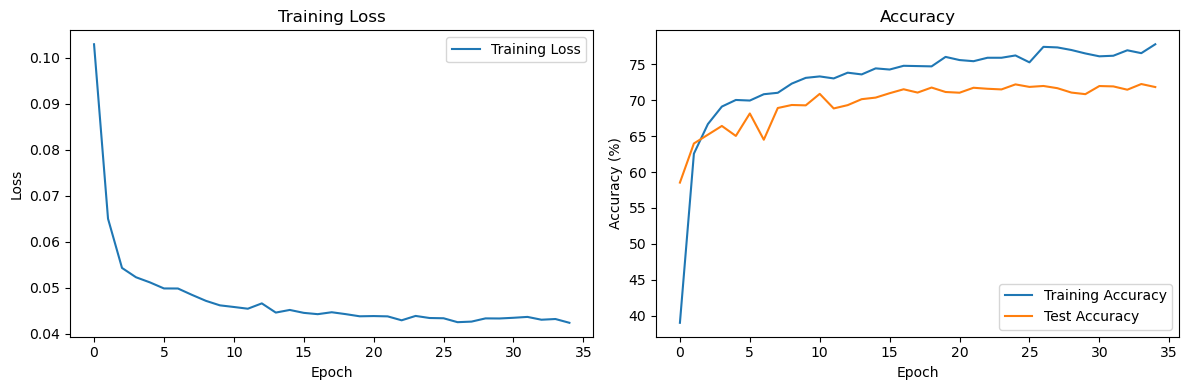

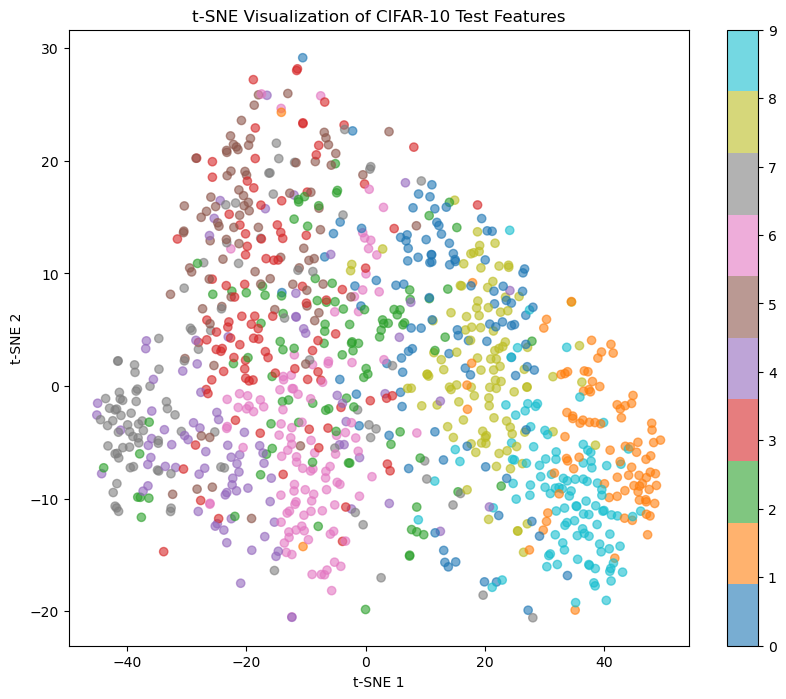

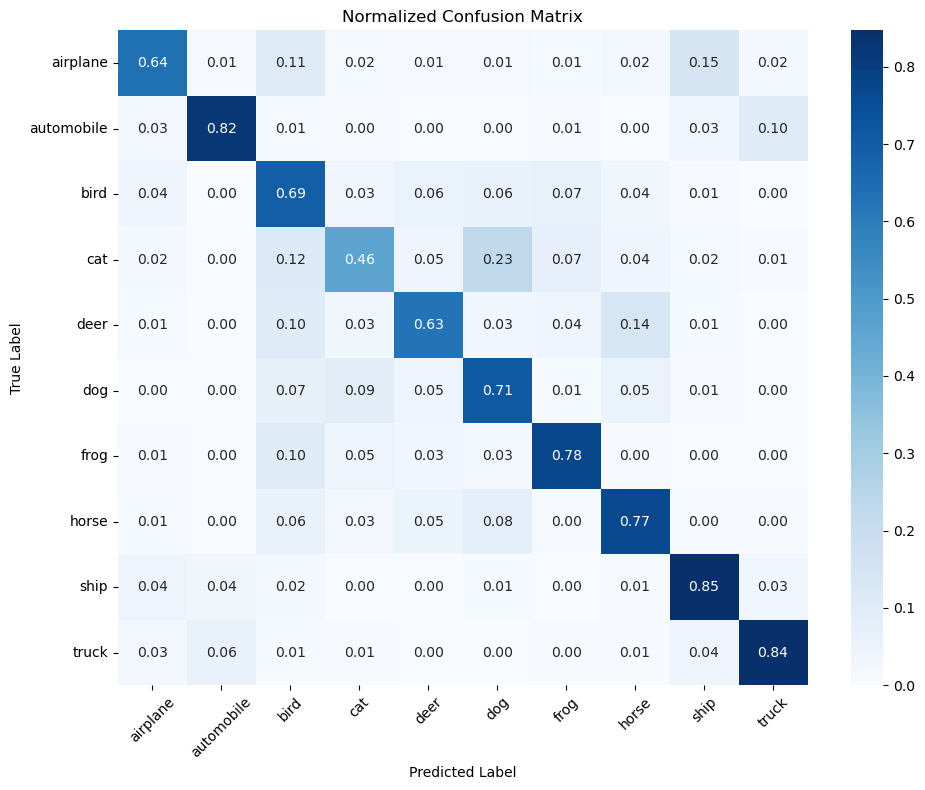

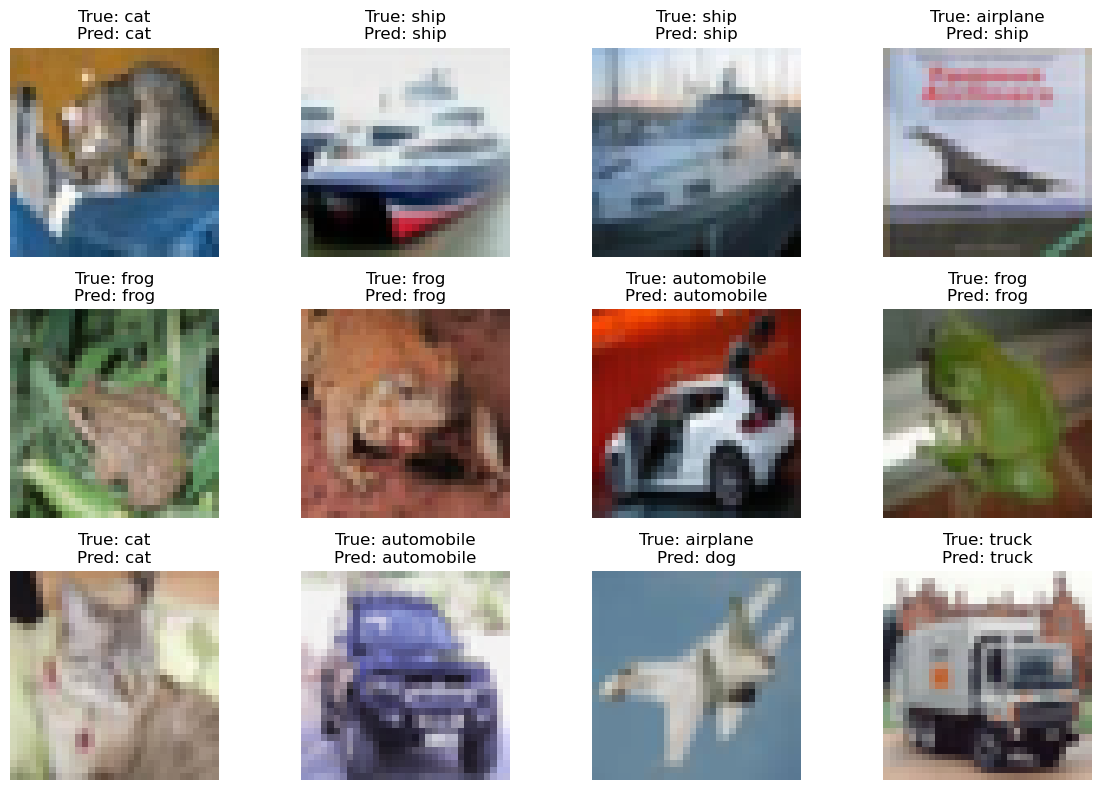

In [ ]:

if __name__ == '__main__':
    main()